<a href="https://colab.research.google.com/github/OmarRodriguezLopez1398/ML_Corrections_Reactions_Training/blob/main/notebook_coimbra.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🧪 Introduction to Machine Learning for Computational Chemistry: Reaction Studies

<p align="center">
  <img src="https://raw.githubusercontent.com/OmarRodriguezLopez1398/ML_Corrections_Reactions_Training/main/IMAGE.png" width="500">
  <br>
  <em>Illustration created for intuitive purposes using Gemini AI</em>
</p>

This tutorial explores the application of **machine learning (ML) techniques** to study chemical reactions. The goal is to predict **energies, reaction barriers, and reaction enthalpies** for a variety of organic reactions using datasets derived from the **[RDB7 database](https://www.nature.com/articles/s41597-022-01529-6)**, with reference calculations performed at the **DFT** level.

The objectives of this tutorial are:

1. Understand how ML models can learn potential energy surfaces of chemical reactions. We will use the **MACE (A Higher Order Equivariant Message Passing Neural Network)** architecture, a machine learning architecture designed to efficiently capture atomic interactions with high accuracy. More details can be found [here](https://mace-docs.readthedocs.io/).
2. Construct and preprocess reaction datasets, including reactants, products, and transition states.
3. Train ML models using **direct energy prediction** and **Δ-learning approaches**.
4. Evaluate the performance of ML models in predicting barrier heights and reaction enthalpies.

# ⚙️ Install Dependencies

Before starting the tutorial, we need to set up the environment and install all required packages. These packages enable **molecular simulations, ML training, and interactive visualization**.

- `mace-torch`: Machine learning model for predicting molecular energies and reaction properties.
- `weas_widget`: Interactive 3D visualization of molecules inside Colab notebooks.
- `tblite==0.4.0`: Lightweight interface to run GFN2-xTB calculations.
- `rdkit`: Molecular toolkit for handling SMILES, molecules, and reactions.
- `ase`: Read, write, and manipulate atomic structures in XYZ format.

> **Note:** Installing these dependencies may take several minutes. After installation, the Colab kernel will be **restarted automatically** to load the new packages.

> **Note:** In Colab, to enable the GPU, click the downward arrow next to Gemini in the top right corner, select "Change runtime type", choose "T4 GPU" under Hardware accelerator, and save the changes. Then click "Connect". If the GPU doesn’t work, replace all instances of "cuda" in the notebook with "cpu".


In [1]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

! uv pip install mace-torch weas_widget tblite==0.4.0 rdkit  --system
get_ipython().kernel.do_shutdown(restart=True)

! pip install ase

# Clone this repository
!git clone https://github.com/OmarRodriguezLopez1398/ML_Corrections_Reactions_Training.git

Using Python 3.12.12 environment at: /usr
Resolved 135 packages in 2.29s
Prepared 18 packages in 2.84s
Installed 18 packages in 290ms
 + appdirs==1.4.4
 + ase==3.27.0
 + configargparse==1.7.1
 + e3nn==0.4.4
 + jedi==0.19.2
 + lightning-utilities==0.15.2
 + lmdb==1.7.5
 + mace-torch==0.3.14
 + matscipy==1.2.0
 + opt-einsum-fx==0.1.4
 + python-hostlist==2.3.0
 + rdkit==2025.9.3
 + seekpath==2.1.0
 + spglib==2.7.0
 + tblite==0.4.0
 + torch-ema==0.3
 + torchmetrics==1.8.2
 + weas-widget==0.2.3
Cloning into 'ML_Corrections_Reactions_Training'...
remote: Enumerating objects: 776, done.
remote: Counting objects: 100% (776/776), done.
remote: Compressing objects: 100% (635/635), done.
remote: Total 776 (delta 384), reused 518 (delta 138), pack-reused 0 (from 0)
Receiving objects: 100% (776/776), 20.70 MiB | 15.55 MiB/s, done.
Resolving deltas: 100% (384/384), done.


In [1]:
# ==================================================
# Global imports for the tutorial
# ==================================================

# Standard library
import os
import random
from collections import defaultdict

# Scientific Python
import numpy as np

# Chemistry / molecular representations
from rdkit import Chem
from rdkit.Chem import rdChemReactions, Draw
from ase.io import read, write

# Visualization and notebook utilities
from IPython.display import display


import ipywidgets as widgets
from weas_widget import WeasWidget


import warnings
from pathlib import Path


from tblite.ase import TBLite
from tqdm import tqdm

# 1. Reaction Dataset 📁

In this tutorial, we use reaction datasets derived from the **[RDB7 database](https://www.nature.com/articles/s41597-022-01529-6)**, a curated benchmark database for for organic gas-phase chemical reactions.  
The atomic structures employed here correspond to **geometry optimizations performed at the DFT level using the $\omega$B97X-D3/def2-TZVP functional**.

From the RDB7 database, we select **two families of reactions**, which serve as representative examples for training and evaluating machine learning models:

1. **1,2 Insertion of CO**  
   - Involves the insertion of a carbon monoxide molecule into a chemical bond.

2. **2+2 Cycloaddition**  
   - A cycloaddition reaction forming a four-membered ring from two unsaturated components.


Each reaction is represented in **XYZ format**, with separate files for:
- Reactants (`r_`)
- Transition states (`ts_`)
- Products (`prod_`)

This structured organization enables systematic dataset construction, metadata assignment, and direct comparison.


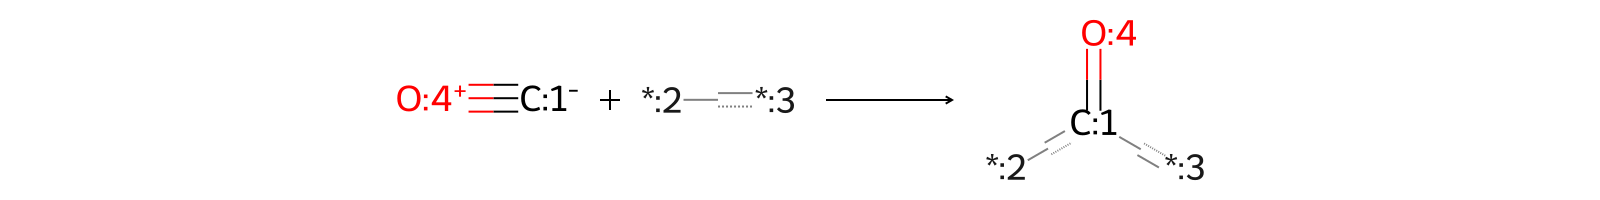

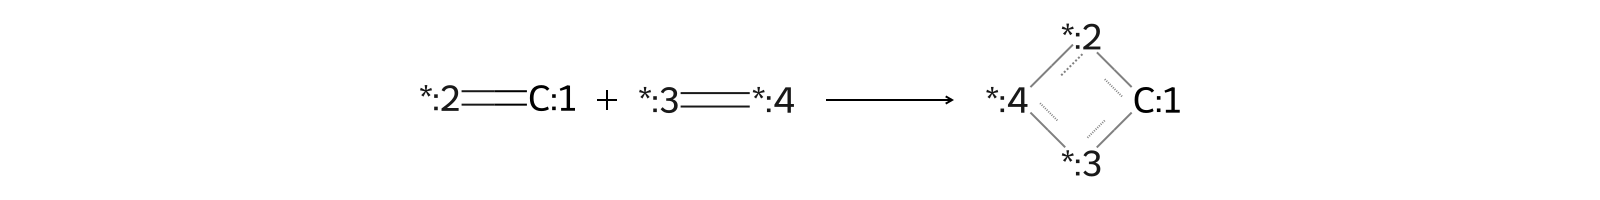

In [2]:
rxn_dict = {
    "1,2 CO Insertion": "[C-:1]#[O+:4].[*:2][*:3]>>[*:2][C:1](=[O:4])[*:3]",
    "2+2 Cycloaddition": "[C:1]=[*:2].[*:3]=[*:4]>>[C:1]1[*:3][*:4][*:2]1"
}
# Convert reaction SMARTS strings into RDKit Reaction objects
reactions = {
    name: rdChemReactions.ReactionFromSmarts(rxn)
    for name, rxn in rxn_dict.items()
}
# --------------------------------------------------
# Visualize the reactions
# --------------------------------------------------
# Each reaction is rendered as an image to verify
# that the SMARTS definition matches the intended chemistry.
for name, rxn in reactions.items():
    img = Draw.ReactionToImage(rxn, subImgSize=(400, 200))
    display(img)



Now, we will count the total number of configurations for each reaction family.

In [3]:
# Root directory containing the reaction datasets
# Each subfolder corresponds to a different reaction class
base_path = "ML_Corrections_Reactions_Training/DATA"

# List of reaction-specific subfolders
reaction_folders = ["1,2_Insertion_CO", "2+2_cycloaddition"]

# Dictionary to store XYZ files grouped by reaction type
all_reactions = {}

for folder in reaction_folders:
    # Full path to the folder containing XYZ files
    xyz_folder = os.path.join(base_path, folder)

    # List and sort all XYZ files in the directory
    files = sorted([f for f in os.listdir(xyz_folder) if f.endswith(".xyz")])
    print(f"\nFolder: {folder}")
    print(f"{len(files)} XYZ files found")

    # Separate files by chemical role using filename prefixes
    # r_    → reactants
    # ts_   → transition states
    # prod_ → products
    reactants = sorted([f for f in files if f.startswith("r_")])
    transition_states = sorted([f for f in files if f.startswith("ts_")])
    products = sorted([f for f in files if f.startswith("prod_")])

    # Print a few examples from each category for sanity checking
    print("Example files by type:")
    print("Reactants:", reactants[:5])
    print("TS:", transition_states[:5])
    print("Products:", products[:5])

    # Store structured information for later processing
    # (e.g., geometry loading, feature extraction, ML training)
    all_reactions[folder] = {
        "path": xyz_folder,
        "reactants": reactants,
        "transition_states": transition_states,
        "products": products
    }



Folder: 1,2_Insertion_CO
136 XYZ files found
Example files by type:
Reactants: ['r_rxn000075_dft_1.xyz', 'r_rxn000623_dft_1.xyz', 'r_rxn001540_dft_1.xyz', 'r_rxn001668_dft_1.xyz', 'r_rxn001788_dft_1.xyz']
TS: ['ts_rxn000075_dft_1.xyz', 'ts_rxn000623_dft_1.xyz', 'ts_rxn001540_dft_1.xyz', 'ts_rxn001668_dft_1.xyz', 'ts_rxn001788_dft_1.xyz']
Products: ['prod_rxn000075_dft_1.xyz', 'prod_rxn000075_dft_2.xyz', 'prod_rxn000623_dft_1.xyz', 'prod_rxn000623_dft_2.xyz', 'prod_rxn001540_dft_1.xyz']

Folder: 2+2_cycloaddition
236 XYZ files found
Example files by type:
Reactants: ['r_rxn000334_dft_1.xyz', 'r_rxn000497_dft_1.xyz', 'r_rxn001323_dft_1.xyz', 'r_rxn001327_dft_1.xyz', 'r_rxn001661_dft_1.xyz']
TS: ['ts_rxn000334_dft_1.xyz', 'ts_rxn000497_dft_1.xyz', 'ts_rxn001323_dft_1.xyz', 'ts_rxn001327_dft_1.xyz', 'ts_rxn001661_dft_1.xyz']
Products: ['prod_rxn000334_dft_1.xyz', 'prod_rxn000334_dft_2.xyz', 'prod_rxn000497_dft_1.xyz', 'prod_rxn000497_dft_2.xyz', 'prod_rxn001323_dft_1.xyz']


### Combining Reaction Geometries into a Single Dataset 🧬

In this step, we collect all molecular geometries (reactants, transition states, and products)
from different reaction classes and merge them into a single XYZ file.

Key ideas:
- **Structures are grouped by reaction**, not shuffled individually.
- Each reaction keeps a chemically meaningful internal order:
  **reactant → transition state → product**.
- Reactions are then randomly shuffled to avoid bias during ML training.
- Metadata (reaction ID, structure type, reaction class) is stored in the XYZ file
  and can later be used for supervised learning, filtering, or stratified splits.


In [4]:
# -----------------------------
# Configuration
# -----------------------------
# Base directory containing all reaction data
base_path = "ML_Corrections_Reactions_Training/DATA"

# List of reaction classes to include
reaction_folders = ["1,2_Insertion_CO", "2+2_cycloaddition"]

# Output XYZ file containing all configurations
combined_xyz = "all_reaction_file.xyz"

# -----------------------------
# Group structures by reaction ID
# -----------------------------
# Dictionary mapping reaction_id -> list of ASE Atoms objects
rxn_dict = defaultdict(list)

for folder in reaction_folders:
    xyz_folder = os.path.join(base_path, folder)

    for fname in os.listdir(xyz_folder):
        if not fname.endswith(".xyz"):
            continue

        # Read geometry using ASE
        at = read(os.path.join(xyz_folder, fname))

        # Determine structure type from filename prefix
        if fname.startswith("r_"):
            structure_type = "reactant"
        elif fname.startswith("ts_"):
            structure_type = "transition_state"
        elif fname.startswith("prod_"):
            structure_type = "product"
        else:
            structure_type = "unknown"

        # Extract reaction ID from filename (e.g., rxn000075)
        try:
            reaction_id = fname.split("_")[1]
        except IndexError:
            reaction_id = "unknown"

        # Store metadata inside the Atoms object
        at.info["structure_type"] = structure_type
        at.info["reaction_id"] = reaction_id
        at.info["reaction_type"] = folder
        at.info["source_file"] = fname

        # Group structures by reaction
        rxn_dict[reaction_id].append(at)

# -----------------------------
# Keep reactions in original order
# -----------------------------
reaction_ids = list(rxn_dict.keys())

# -----------------------------
# Build final ordered list of structures
# -----------------------------
all_atoms = []

# Recommended chemical order within each reaction
order = ["reactant", "transition_state", "product"]

for rxn_id in reaction_ids:
    configs = rxn_dict[rxn_id]

    # Sort structures within the same reaction
    configs_sorted = sorted(
        configs,
        key=lambda at: order.index(at.info["structure_type"])
        if at.info["structure_type"] in order else 99
    )

    all_atoms.extend(configs_sorted)

# -----------------------------
# Write combined XYZ file
# -----------------------------
write(combined_xyz, all_atoms)

print(f"Combined XYZ file created: {combined_xyz}")
print(f"Total number of configurations: {len(all_atoms)}")
print(f"Total number of reactions: {len(reaction_ids)}")


Combined XYZ file created: all_reaction_file.xyz
Total number of configurations: 372
Total number of reactions: 93


In this step, we read the file that contains all molecular configurations for the reactions.   We also explain how each configuration is converted into numerical arrays, which represent the atomic positions, elements, and other relevant features.  
These arrays serve as the input for the machine learning models.


In [5]:
# Read all configurations from the combined XYZ file
db = read("all_reaction_file.xyz", ":")

# -----------------------------
# Basic dataset checks
# -----------------------------
print("Number of configurations in the database:", len(db))

# Number of atoms in each configuration
n_atoms = np.array([len(at) for at in db])
print("Number of atoms in each configuration:", n_atoms)

# Minimum number of atoms across all configurations
# Useful to check that no isolated atoms or empty structures are present
print(
    "Number of atoms in the smallest configuration:",
    np.min(n_atoms)
)

# -----------------------------
# Inspect stored metadata
# -----------------------------
# Metadata added during dataset construction is stored in at.info
# This information is critical for filtering, grouping, or labeling data in ML workflows
print("\nInformation stored in config.info:\n", db[10].info)

# Atomic-level arrays (e.g., positions, forces if present) are stored in at.arrays
print("\nInformation stored in config.arrays:\n", db[10].arrays)



Number of configurations in the database: 372
Number of atoms in each configuration: [14 14 12  2 12 12 10  2 11 11  9  2 10 10  8  2  8  8  6  2 18 18  2 16
 13 13  2 11 11 11  2  9 10 10  2  8 19 19  2 17 14 14  2 12  9  9  2  7
  5  5  3  2 13 13 11  2 12 12  2 10 16 16  2 14 14 14  2 12 12 12 10  2
 11 11  2  9 12 12  2 10 13 13 11  2  6  6  4  2 12 12  2 10 11 11  2  9
 17 17 15  2 11 11  2  9  9  9  2  7 13 13  2 11 12 12 10  2 15 15 13  2
 16 16 14  2  8  8  6  2 12 12  2 10 12 12  2 10 13 13  9  4 15 15 11  4
 13 13  4  9 16 16 12  4 11 11  4  7 17 17 10  7 14 14  4 10 17 17 13  4
 12 12  4  8 14 14 10  4 13 13  3 10 13 13  9  4 15 15  4 11 11 11  7  4
 14 14 10  4 12 12  8  4 10 10  4  6 13 13  7  6 14 14  7  7 17 17  4 13
 12 12  3  9 12 12  3  9 10 10  4  6 12 12  9  3 13 13  9  4 14 14 10  4
 14 14  4 10 11 11  4  7  9  9  5  4 12 12  4  8 11 11  7  4 15 15  4 11
 12 12  8  4 16 16  7  9 12 12  8  4 16 16 12  4 14 14  4 10 11 11  4  7
 12 12  4  8 16 16 12  4 14 14  4 10 17

## Visualizing a Single Reaction Pathway 👀

In this step, we extract all configurations corresponding to a **single reaction** from the combined dataset and visualize them in a chemically meaningful order.

**Key points:**
- Each reaction is uniquely identified by its `reaction_id`.
- Interactive 3D viewers are created for each molecular structure.
- Displaying the structures side by side illustrates the structural changes along the reaction coordinate.

**📚 Task:** Try selecting a different reaction and observe how the reaction pathway is displayed.


In [6]:
# -----------------------------
# Load the combined database
# -----------------------------
db = read("all_reaction_file.xyz", ":")

# -----------------------------
# Select a single reaction by ID
# -----------------------------
rxn_id = "rxn000334"

# Filter all configurations belonging to the selected reaction
rxn_configs = [at for at in db if at.info["reaction_id"] == rxn_id]

# Chemical ordering: reactant -> transition state -> product
order = ["reactant", "transition_state", "product"]
rxn_configs_sorted = sorted(
    rxn_configs,
    key=lambda at: order.index(at.info["structure_type"])
)

# Print basic information for verification
print(f"Visualizing reaction {rxn_id}")
for at in rxn_configs_sorted:
    print(at.info["structure_type"], at.info["source_file"])

# -----------------------------
# Create WEAS viewers
# -----------------------------
# One interactive 3D viewer per structure
viewers = []

for atoms in rxn_configs_sorted:
    viewer = WeasWidget()
    viewer.from_ase(atoms)

    # Visualization settings
    viewer.avr.model_style = 0            # ball-and-stick representation
    viewer.avr.show_hydrogen_bonds = False

    # Descriptive title shown in the viewer
    viewer.title = f"{rxn_id} | {atoms.info['structure_type']}"

    viewers.append(viewer)

# -----------------------------
# Layout: side-by-side visualization
# -----------------------------
# Display all viewers in a horizontal layout
display(widgets.HBox(viewers))


Visualizing reaction rxn000334
reactant r_rxn000334_dft_1.xyz
transition_state ts_rxn000334_dft_1.xyz
product prod_rxn000334_dft_1.xyz
product prod_rxn000334_dft_2.xyz


## Adding Isolated Atoms to the Dataset 🧬

Before training machine learning interatomic potentials (MLIPs) such as **MACE**,  
the dataset must include **isolated atoms** for each chemical element present.

MLIPs are typically trained on **atomization energies**, which require a reference energy for each individual atom.  

In our case, the isolated atoms, **C, O, N, and H** will be added.  
The resulting XYZ file will be named `dataset_final.xyz`.

**In this step:**
- We load precomputed isolated-atom configurations obtained at the DFT level.
- We assign consistent metadata labels so the atoms can be easily identified.
- The isolated atoms are placed at the beginning of the dataset, before the reaction data.

Placing the isolated atoms first is done for convenience; their order does **not** affect the training procedure.


In [7]:
# -----------------------------
# File paths
# -----------------------------
# Path to XYZ file containing isolated atoms (H, C, O)
# Adjust this path to match your directory structure
isolated_atoms_path = "/content/ML_Corrections_Reactions_Training/DATA/isolated_atoms.xyz"

# Reaction dataset (previously generated)
reaction_xyz_path = "all_reaction_file.xyz"

# Final dataset including isolated atoms + reactions
final_xyz_path = "dataset_final.xyz"

# -----------------------------
# Read isolated atoms
# -----------------------------
# Each frame should contain a single atom in vacuum
isolated_atoms = read(isolated_atoms_path, ":")

print(f"Number of isolated-atom configurations: {len(isolated_atoms)}")

# Ensure consistent metadata for ML training
for at in isolated_atoms:
    at.info["structure_type"] = "isolated_atom"
    at.info["reaction_id"] = "isolated"
    at.info["source_file"] = "isolated_atoms.xyz"

# -----------------------------
# Read reaction configurations
# -----------------------------
reaction_atoms = read(reaction_xyz_path, ":")

print(f"Number of reaction configurations: {len(reaction_atoms)}")

# -----------------------------
# Concatenate datasets (isolated atoms first)
# -----------------------------
all_atoms = isolated_atoms + reaction_atoms

# -----------------------------
# Write final dataset
# -----------------------------
write(final_xyz_path, all_atoms)

print(f"\nFinal dataset created: {final_xyz_path}")
print(f"Total number of configurations: {len(all_atoms)}")


Number of isolated-atom configurations: 4
Number of reaction configurations: 372

Final dataset created: dataset_final.xyz
Total number of configurations: 376


# 2. Direct training procedure 🤖

## Splitting the Dataset into Train and Test Sets

For machine learning workflows, the dataset is split as follows:

- **Isolated atoms** are included **only in the training set**.  
- **Reactions** are grouped by `reaction_id`, and the train/test split is performed randomly by reaction, ensuring that the same reaction does **not** appear in both sets.

The dataset fractions for training and testing are defined as:  
- **Train:** 90% of reactions (saved as `train.xyz`)  
- **Test:** 10% of reactions (saved as `test.xyz`)


In [8]:
# -----------------------------
# Configuration
# -----------------------------
dataset_path = "dataset_final.xyz"
train_frac = 0.9
test_frac = 0.1
random_seed = 42

random.seed(random_seed)

# -----------------------------
# Read the full dataset
# -----------------------------
db = read(dataset_path, ":")

# -----------------------------
# Separate isolated atoms from reaction configurations
# -----------------------------
isolated_atoms = [at for at in db if at.info["structure_type"] == "isolated_atom"]
reaction_atoms = [at for at in db if at.info["structure_type"] != "isolated_atom"]

print(f"Isolated atoms: {len(isolated_atoms)}")
print(f"Reaction configurations: {len(reaction_atoms)}")

# -----------------------------
# Group reaction configurations by reaction ID
# -----------------------------
rxn_dict = defaultdict(list)
for at in reaction_atoms:
    rxn_id = at.info["reaction_id"]
    rxn_dict[rxn_id].append(at)

reaction_ids = list(rxn_dict.keys())
random.shuffle(reaction_ids)  # Shuffle reactions before splitting

# -----------------------------
# Split reactions into train/test
# -----------------------------
n_rxns = len(reaction_ids)
n_train = int(train_frac * n_rxns)

train_rxns = reaction_ids[:n_train]
test_rxns = reaction_ids[n_train:]

print(f"Reactions → train: {len(train_rxns)}, test: {len(test_rxns)}")

# -----------------------------
# Build final datasets
# -----------------------------
# Isolated atoms are included only in the training set
train_atoms = isolated_atoms.copy()
test_atoms = []

for rxn_id in train_rxns:
    train_atoms.extend(rxn_dict[rxn_id])

for rxn_id in test_rxns:
    test_atoms.extend(rxn_dict[rxn_id])

# -----------------------------
# Write XYZ files for each split
# -----------------------------
write("train.xyz", train_atoms)
write("test.xyz", test_atoms)

print("\nFiles created:")
print(f"train.xyz → {len(train_atoms)} configurations")
print(f"test.xyz  → {len(test_atoms)} configurations")


Isolated atoms: 4
Reaction configurations: 372
Reactions → train: 83, test: 10

Files created:
train.xyz → 336 configurations
test.xyz  → 40 configurations


## MACE Model Configuration 🔧

This YAML file defines the settings for training a **MACE** ML
model on our reaction dataset.

Key points:

- **Model architecture**:
  - `num_channels`: number of channels in the message-passing layers
  - `max_L`: maximum angular momentum
  - `r_max`: cutoff radius for atomic neighborhoods

- **Directories**:
  - `model_dir`, `log_dir`, `checkpoints_dir`, `results_dir` specify
    where the model and training outputs are stored

- **Training data**:
  - `train_file` and `test_file` specify the XYZ datasets
  - `valid_fraction` defines the fraction of training set used for validation

- **Training targets**:
  - `energy_key` and `forces_key` tell MACE which properties to predict
  - `error_table` specifies the metric for evaluating performance

- **Optimization**:
  - `weight_decay`, `clip_grad`, `ema`, and `swa` are optimizer-related settings
  - `batch_size` and `max_num_epochs` control training iterations

- **Hardware**:
  - `device`: CPU or GPU
  - `seed`: ensures reproducibility

For more detailed information on all available options, model architectures, and
training workflows, visit the **MACE documentation**: [MACE Documentation](https://github.com/ACEsuit/MACE)


Creating a Folder to Store Training Configuration YAML files

In [9]:
warnings.filterwarnings("ignore")

Path("config/").mkdir(parents=True, exist_ok=True)

In [10]:
%%writefile config/config-01.yml

model: "MACE"
num_channels: 32
max_L: 0
r_max: 4.0

name: "MACE_DIRECT_RXN"
model_dir: "MACE_DIRECT_MODEL"
log_dir: "MACE_DIRECT_MODEL"
checkpoints_dir: "MACE_DIRECT_MODEL"
results_dir: "MACE_DIRECT_MODEL"

train_file: "train.xyz"
valid_fraction: 0.05
test_file: "test.xyz"

energy_key: "energy_dft"
forces_key: "forces_dft"
error_table: "PerAtomMAE"
weight_decay: 5e-10
clip_grad: 1.0
ema: True
swa: True
swa_lr: 0.00025
swa_forces_weight: 10

device: cpu
batch_size: 10
max_num_epochs: 100
seed: 123


Writing config/config-01.yml


In [11]:
#device = 'cuda'
device = 'cpu' #[Remember to change this if you are using cpu configuration]
dev = f'device: {device}'
%store dev >>"config/config-01.yml"

Writing 'dev' (str) to file 'config/config-01.yml'.


## Training the MACE Model ⚡

We now launch the training of the MACE model using the configuration defined
in `config/config-01.yml`.

Key points:

- The command `mace_run_train --config config/config-01.yml` starts the training process.
- If you are running on CPU, explicitly pass `--device=cpu` to avoid errors.
- Existing model checkpoints may conflict with a new training run, especially
  if the model architecture has changed.
- Therefore, we remove old checkpoint files (`*_run-*.model` and `*.pt`)
  before starting a new training session.
- This ensures a clean start and prevents unexpected errors during retraining.


> **Note:** Training procedure may take a few minutes.

In [12]:
# -----------------------------
# Train the MACE model
# -----------------------------
# This runs MACE training using the specified configuration file
# Use '--device=cpu' if running on CPU
!mace_run_train --config config/config-01.yml
# -----------------------------
# Clean up old checkpoints
# -----------------------------
p = Path("MACE_DIRECT_MODEL/")
# Delete model checkpoint files
_ = [file.unlink() for file in p.glob("*_run-*.model")]
# Delete PyTorch state files
_ = [file.unlink() for file in p.glob("*.pt")]


print(" Great! Training is complete ✅")

/usr/local/lib/python3.12/dist-packages/e3nn/o3/_wigner.py:10: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  _Jd, _W3j_flat, _W3j_indices = torch.load(os.path.join(os.path.dirname(__file__), 'constants.pt'))
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
2026-01-14 17:22:00.920 INFO: ===========VERIFYING SETTINGS===========
2026-01-14 17:22:00.920 INFO: MACE version: 0.3.14
2026-01-14 17:22:00.920 INFO: Using CPU
2026-01-14 17:22:01.181 INFO: ===========LOADING INPUT DATA===========
2026-01-14 17:22:01.181 INFO: Using heads: ['Default']
2026-01-14 17:22:01.181 INFO: Using the key specifications to parse data:
2026-01-14 17:22:01.181 INFO: Default: KeySpecification(info_keys={'energy': 'energy_dft', 'stress': 'REF_stress', 'virials': 'REF_virials', 'dipole': 'dipole', 'head': 'head', 'elec_temp': 

**📚 Task:** At first glance, the model does not seem to have converged yet. Try training it for more than **100 iterations** and observe how the results change.


# 3. Evaluating the Trained MACE Model 💻

After training, we evaluate the model on both the **training set** and the **test set**
to check its performance.

Key points:

- We create a folder `tests/RXN_DIRECT_EVALUATION/` to store the evaluation outputs.
- `mace_eval_configs` computes predicted energies and forces for each configuration in the specified XYZ file.
- The `--model` argument points to the trained MACE model checkpoint.
- The `--output` argument specifies the file where predictions will be stored.
- Evaluating both the training and test sets allows us to:
  - verify that the model reproduces training data accurately
  - measure generalization to unseen reactions (test set)


In [13]:
# -----------------------------
# Ignore warnings for cleaner output
# -----------------------------
warnings.filterwarnings("ignore")

# -----------------------------
# Create folder to store evaluation results
# -----------------------------
Path("tests/RXN_DIRECT_EVALUATION/").mkdir(parents=True, exist_ok=True)

# -----------------------------
# Evaluate the training set
# -----------------------------
!mace_eval_configs \
    --configs="train.xyz" \
    --model="MACE_DIRECT_MODEL/MACE_DIRECT_RXN_stagetwo_compiled.model" \
    --output="tests/RXN_DIRECT_EVALUATION/train_direct_predicted.xyz"

# -----------------------------
# Evaluate the test set
# -----------------------------
!mace_eval_configs \
    --configs="test.xyz" \
    --model="MACE_DIRECT_MODEL/MACE_DIRECT_RXN_stagetwo_compiled.model" \
    --output="tests/RXN_DIRECT_EVALUATION/test_direct_predicted.xyz"

print(" Great! Evaluation is complete ✅")


/usr/local/lib/python3.12/dist-packages/e3nn/o3/_wigner.py:10: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  _Jd, _W3j_flat, _W3j_indices = torch.load(os.path.join(os.path.dirname(__file__), 'constants.pt'))
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
/usr/local/lib/python3.12/dist-packages/mace/cli/eval_configs.py:140: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  model = torch.load(f=args.model, map_location=args.device)
/usr/local/lib/python3.12/dist-packages/torch/serialization.py:1493: UserWarning: 'torch.load' received a zip file that looks like a TorchScript archive dispatching to 'torch.jit.load' (call 'torch.jit.load' directly to silence this warning

## Compute Per-Structure MAE for Train and Test Sets 🧮

In this step, we calculate the **Mean Absolute Error (MAE)** between the DFT reference energies and the MACE-predicted energies for each type of structure:

- **Reactants**
- **Transition States**
- **Products**

Key points:

- Energies are converted from eV to kcal/mol for readability.
- MAE is computed separately for each type to identify where the model
  performs best or worst.


In [14]:
# Conversion factor: eV → kcal/mol
EV2KCAL = 23.0609

def print_energy_MAE_by_type(db, label=''):
    """
    Compute and print MAE between DFT and MACE energies for each structure type.
    """
    # Define structure types
    types = ['reactant', 'transition_state', 'product']

    for t in types:
        # Filter configurations by type
        atoms_t = [at for at in db if at.info['structure_type'] == t]

        if len(atoms_t) == 0:
            continue

        # Extract energies and convert units
        E_DFT = np.array([at.info['energy_dft'] for at in atoms_t]) * EV2KCAL
        E_MACE = np.array([at.info['MACE_energy'] for at in atoms_t]) * EV2KCAL

        # Compute MAE
        mae = np.mean(np.abs(E_DFT - E_MACE))
        print(f"{label} | {t} MAE = {mae:.3f} kcal/mol")

# -----------------------------
# Read datasets
# -----------------------------
train_data = read('tests/RXN_DIRECT_EVALUATION/train_direct_predicted.xyz', ':')
test_data = read('tests/RXN_DIRECT_EVALUATION/test_direct_predicted.xyz', ':')

# -----------------------------
# Compute and print MAE
# -----------------------------
print_energy_MAE_by_type(train_data, label='Train')
print_energy_MAE_by_type(test_data, label='Test')


Train | reactant MAE = 23.012 kcal/mol
Train | transition_state MAE = 32.593 kcal/mol
Train | product MAE = 7.875 kcal/mol
Test | reactant MAE = 28.383 kcal/mol
Test | transition_state MAE = 38.930 kcal/mol
Test | product MAE = 7.587 kcal/mol


## Reaction Enthalpies and Barrier Heights 🧪

Let's see how the trained model **predicts barrier heights (BH) and reaction enthalpies (RE)**.

For each reaction, we can define:

1. **Barrier heights** (transition state energy relative to reactants):

$$
\Delta E^\ddagger = E_\text{TS} - E_\text{R}
$$

2. **Reaction enthalpy** (products relative to reactants):

$$
\Delta H^r = E_\text{P} - E_\text{R}
$$

For reactions with multiple products, the **total product energy** is the sum of all product energies:

$$
E_\text{P,total} = \sum_{i} E_{\text{P},i}
$$



In [16]:
# -----------------------------
# Function to compute barriers and reaction enthalpies
# -----------------------------
def compute_barriers_entalpies(db):
    rxn_dict = defaultdict(list)
    for at in db:
        rxn_dict[at.info['reaction_id']].append(at)

    results = []
    for rxn_id, atoms in rxn_dict.items():
        # Separate by structure type
        R_atoms = [at for at in atoms if at.info['structure_type'] == 'reactant']
        TS_atoms = [at for at in atoms if at.info['structure_type'] == 'transition_state']
        P_atoms = [at for at in atoms if at.info['structure_type'] == 'product']

        if len(R_atoms) == 0 or len(TS_atoms) == 0 or len(P_atoms) == 0:
            continue

        # Average energies for reactants, TS, and total products
        E_R_DFT = np.mean([at.info['energy_dft'] for at in R_atoms])
        E_R_MACE = np.mean([at.info['MACE_energy'] for at in R_atoms])

        E_TS_DFT = np.mean([at.info['energy_dft'] for at in TS_atoms])
        E_TS_MACE = np.mean([at.info['MACE_energy'] for at in TS_atoms])

        E_P_DFT = sum([at.info['energy_dft'] for at in P_atoms])
        E_P_MACE = sum([at.info['MACE_energy'] for at in P_atoms])

        # Compute barriers and enthalpies in kcal/mol
        barrier_DFT = (E_TS_DFT - E_R_DFT) * EV2KCAL
        barrier_MACE = (E_TS_MACE - E_R_MACE) * EV2KCAL
        deltaH_DFT = (E_P_DFT - E_R_DFT) * EV2KCAL
        deltaH_MACE = (E_P_MACE - E_R_MACE) * EV2KCAL

        rxn_type = R_atoms[0].info.get('reaction_type', 'unknown')

        results.append({
            'reaction_id': rxn_id,
            'reaction_type': rxn_type,
            'barrier_DFT': barrier_DFT,
            'barrier_MACE': barrier_MACE,
            'deltaH_DFT': deltaH_DFT,
            'deltaH_MACE': deltaH_MACE
        })
    return results

# -----------------------------
# Function to print MAEs
# -----------------------------
def print_MAEs(results, label=''):
    types = set([r['reaction_type'] for r in results])
    print(f"\nMAEs {label} dataset (kcal/mol):\n")
    for t in types:
        r_type = [r for r in results if r['reaction_type'] == t]
        barrier_MAE = np.mean([abs(r['barrier_DFT'] - r['barrier_MACE']) for r in r_type])
        deltaH_MAE = np.mean([abs(r['deltaH_DFT'] - r['deltaH_MACE']) for r in r_type])
        print(f"{t}: BH MAE = {barrier_MAE:.3f}, RE MAE = {deltaH_MAE:.3f}")

# -----------------------------
# Read evaluation datasets
# -----------------------------
train_data = read('tests/RXN_DIRECT_EVALUATION/train_direct_predicted.xyz', ':')
test_data = read('tests/RXN_DIRECT_EVALUATION/test_direct_predicted.xyz', ':')

# -----------------------------
# Evaluate Train
# -----------------------------
train_results = compute_barriers_entalpies(train_data)
print_MAEs(train_results, label='Train')

# -----------------------------
# Evaluate Test
# -----------------------------
test_results = compute_barriers_entalpies(test_data)
print_MAEs(test_results, label='Test')


MAEs Train dataset (kcal/mol):

2+2_cycloaddition: BH MAE = 43.327, RE MAE = 15.743
1,2_Insertion_CO: BH MAE = 68.705, RE MAE = 24.309

MAEs Test dataset (kcal/mol):

2+2_cycloaddition: BH MAE = 38.580, RE MAE = 14.885
1,2_Insertion_CO: BH MAE = 79.628, RE MAE = 31.228


These initial results appear to be quite poor. This is expected because, for reaction datasets, building an accurate machine learning potential requires **a very large amount of data**. Not only do we need information about the **energy minima**, but we also need data for **transition states** and **intermediate structures** along the reaction pathways. Typically, millions of structures are required to properly capture the energy surfaces along reaction coordinates.

Today, there are some machine learning potentials capable of reasonably capturing transition states (TS) and predicting barrier heights (BHs) and reaction energies (REs). Examples include:

- **AIQM2**: Combines a semiempirical quantum mechanical (SQM) method, an ensemble of eight ANI-type neural networks (NNs). More information can be found [here](https://pubs.rsc.org/en/content/articlelanding/2025/sc/d5sc02802g).

- **DeePHF**: A $\Delta$ -learning approach. The Deep post-Hartree-Fock method (DeePHF) uses eigenvalues of local density matrices, computed with low-level electronic structure methods, as neural network input features. More information is available [here](https://pubs.acs.org/doi/full/10.1021/jacsau.5c00541).

- **ANI Potentials**: Neural network potentials trained on large datasets of molecular structures to predict energies and forces efficiently. More information can be found [here](https://pubs.acs.org/doi/10.1021/acs.jctc.5c00347).

For higher accuracy, we have previously trained a more powerful model with greater complexity, using **over 11,000 reactions** (the trained model is available in the folder: `MyModel/`). Let’s now examine the results obtained with this model.


First, we will evaluate the results again using the imported model. This step will take slightly more time than the previous one.


In [17]:
# -----------------------------
# Ignore warnings for cleaner output
# -----------------------------
warnings.filterwarnings("ignore")

# -----------------------------
# Create folder to store evaluation results
# -----------------------------
#Path("tests/RXN_DIRECT_EVALUATION/").mkdir(parents=True, exist_ok=True)

# -----------------------------
# Evaluate the training set
# -----------------------------
!mace_eval_configs \
    --configs="train.xyz" \
    --model="ML_Corrections_Reactions_Training/MyModel/11k_rxn_direct.model" \
    --output="tests/RXN_DIRECT_EVALUATION/train_direct_predicted_by_11k.xyz"

# -----------------------------
# Evaluate the test set
# -----------------------------
!mace_eval_configs \
    --configs="test.xyz" \
    --model="ML_Corrections_Reactions_Training/MyModel/11k_rxn_direct.model" \
    --output="tests/RXN_DIRECT_EVALUATION/test_direct_predicted_by_11k.xyz"

print(" Great! Evaluation is complete ✅")


/usr/local/lib/python3.12/dist-packages/e3nn/o3/_wigner.py:10: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  _Jd, _W3j_flat, _W3j_indices = torch.load(os.path.join(os.path.dirname(__file__), 'constants.pt'))
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
/usr/local/lib/python3.12/dist-packages/mace/cli/eval_configs.py:140: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  model = torch.load(f=args.model, map_location=args.device)
/usr/local/lib/python3.12/dist-packages/torch/serialization.py:1493: UserWarning: 'torch.load' received a zip file that looks like a TorchScript archive dispatching to 'torch.jit.load' (call 'torch.jit.load' directly to silence this warning

fhashgdo

In [18]:
def print_energy_MAE_by_type(db, label=''):
    """
    Compute and print MAE between DFT and MACE energies for each structure type.
    """
    # Define structure types
    types = ['reactant', 'transition_state', 'product']

    for t in types:
        # Filter configurations by type
        atoms_t = [at for at in db if at.info['structure_type'] == t]

        if len(atoms_t) == 0:
            continue

        # Extract energies and convert units
        E_DFT = np.array([at.info['energy_dft'] for at in atoms_t]) * EV2KCAL
        E_MACE = np.array([at.info['MACE_energy'] for at in atoms_t]) * EV2KCAL

        # Compute MAE
        mae = np.mean(np.abs(E_DFT - E_MACE))
        print(f"{label} | {t} MAE = {mae:.3f} kcal/mol")

# -----------------------------
# Read datasets
# -----------------------------
train_data = read('tests/RXN_DIRECT_EVALUATION/train_direct_predicted_by_11k.xyz', ':')
test_data = read('tests/RXN_DIRECT_EVALUATION/test_direct_predicted_by_11k.xyz', ':')

# -----------------------------
# Compute and print MAE
# -----------------------------
print_energy_MAE_by_type(train_data, label='Train')
print_energy_MAE_by_type(test_data, label='Test')


Train | reactant MAE = 0.173 kcal/mol
Train | transition_state MAE = 1.118 kcal/mol
Train | product MAE = 0.115 kcal/mol
Test | reactant MAE = 0.092 kcal/mol
Test | transition_state MAE = 0.818 kcal/mol
Test | product MAE = 0.113 kcal/mol


In [19]:
# -----------------------------
# Function to compute barriers and reaction enthalpies
# -----------------------------
def compute_barriers_entalpies(db):
    rxn_dict = defaultdict(list)
    for at in db:
        rxn_dict[at.info['reaction_id']].append(at)

    results = []
    for rxn_id, atoms in rxn_dict.items():
        # Separate by structure type
        R_atoms = [at for at in atoms if at.info['structure_type'] == 'reactant']
        TS_atoms = [at for at in atoms if at.info['structure_type'] == 'transition_state']
        P_atoms = [at for at in atoms if at.info['structure_type'] == 'product']

        if len(R_atoms) == 0 or len(TS_atoms) == 0 or len(P_atoms) == 0:
            continue

        # Average energies for reactants, TS, and total products
        E_R_DFT = np.mean([at.info['energy_dft'] for at in R_atoms])
        E_R_MACE = np.mean([at.info['MACE_energy'] for at in R_atoms])

        E_TS_DFT = np.mean([at.info['energy_dft'] for at in TS_atoms])
        E_TS_MACE = np.mean([at.info['MACE_energy'] for at in TS_atoms])

        E_P_DFT = sum([at.info['energy_dft'] for at in P_atoms])
        E_P_MACE = sum([at.info['MACE_energy'] for at in P_atoms])

        # Compute barriers and enthalpies in kcal/mol
        barrier_DFT = (E_TS_DFT - E_R_DFT) * EV2KCAL
        barrier_MACE = (E_TS_MACE - E_R_MACE) * EV2KCAL
        deltaH_DFT = (E_P_DFT - E_R_DFT) * EV2KCAL
        deltaH_MACE = (E_P_MACE - E_R_MACE) * EV2KCAL

        rxn_type = R_atoms[0].info.get('reaction_type', 'unknown')

        results.append({
            'reaction_id': rxn_id,
            'reaction_type': rxn_type,
            'barrier_DFT': barrier_DFT,
            'barrier_MACE': barrier_MACE,
            'deltaH_DFT': deltaH_DFT,
            'deltaH_MACE': deltaH_MACE
        })
    return results

# -----------------------------
# Function to print MAEs
# -----------------------------
def print_MAEs(results, label=''):
    types = set([r['reaction_type'] for r in results])
    print(f"\nMAEs {label} dataset (kcal/mol):\n")
    for t in types:
        r_type = [r for r in results if r['reaction_type'] == t]
        barrier_MAE = np.mean([abs(r['barrier_DFT'] - r['barrier_MACE']) for r in r_type])
        deltaH_MAE = np.mean([abs(r['deltaH_DFT'] - r['deltaH_MACE']) for r in r_type])
        print(f"{t}: BH MAE = {barrier_MAE:.3f}, RE MAE = {deltaH_MAE:.3f}")

# -----------------------------
# Read evaluation datasets
# -----------------------------
train_data = read('tests/RXN_DIRECT_EVALUATION/train_direct_predicted_by_11k.xyz', ':')
test_data = read('tests/RXN_DIRECT_EVALUATION/test_direct_predicted_by_11k.xyz', ':')

# -----------------------------
# Evaluate Train
# -----------------------------
train_results = compute_barriers_entalpies(train_data)
print_MAEs(train_results, label='Train')

# -----------------------------
# Evaluate Test
# -----------------------------
test_results = compute_barriers_entalpies(test_data)
print_MAEs(test_results, label='Test')


MAEs Train dataset (kcal/mol):

2+2_cycloaddition: BH MAE = 1.221, RE MAE = 0.329
1,2_Insertion_CO: BH MAE = 0.844, RE MAE = 0.269

MAEs Test dataset (kcal/mol):

2+2_cycloaddition: BH MAE = 0.311, RE MAE = 0.368
1,2_Insertion_CO: BH MAE = 1.043, RE MAE = 0.165


# Delta Learning with GFN2-xTB

Before training a delta-learning model, we need a **lower-level reference method**
that provides fast but approximate energies. In this tutorial, we use **GFN2-xTB**.

GFN2-xTB is a semi-empirical tight-binding method that:
- Is several orders of magnitude faster than DFT
- Provides reasonable geometries and energetics for organic reactions
- Is widely used as a baseline for machine-learning corrections

### Delta learning idea

Instead of learning DFT energies directly, we train a model to learn the **difference**
between a high-level reference (DFT) and a lower-level method (xTB):

$$
\Delta E = E^{\text{DFT}} - E^{\text{xTB}}
$$

At prediction time:
1. Compute $E^{\text{xTB}}$ cheaply
2. Predict $\Delta E$ with the ML model
3. Recover the DFT-quality energy as:
$$
E^{\text{DFT}} \approx E^{\text{xTB}} + \Delta E_{\text{ML}}
$$

In this step, we compute **single-point GFN2-xTB energies** for all configurations
in the dataset and store them alongside the DFT data.



In [ ]:
# -----------------------------
# Read DFT-based dataset
# -----------------------------
# This dataset already contains DFT energies and metadata
db = read("all_reaction_configs_random_both.xyz", ":")

print(f"Total number of configurations: {len(db)}")

# -----------------------------
# Set up xTB calculator (single-point)
# -----------------------------
xtb_calc = TBLite(method="GFN2-xTB", verbosity=0)

# -----------------------------
# Single-point energy evaluation
# -----------------------------
# We compute xTB energies on fixed geometries (no relaxation)
for at in tqdm(db, desc="Computing GFN2-xTB energies"):
    at.calc = xtb_calc
    at.info["energy_xtb"] = at.get_potential_energy()

    # Keep only essential atomic arrays to avoid bloated XYZ files
    essential_arrays = {"positions", "numbers"}
    for key in list(at.arrays.keys()):
        if key not in essential_arrays:
            at.arrays.pop(key)

# -----------------------------
# Write clean XYZ file
# -----------------------------
# write_results=False is crucial to prevent ASE from
# duplicating energies/forces in the arrays section
write(
    "all_reaction_configs_xtb_sp.xyz",
    db,
    write_results=False
)
print("File written successfully: all_reaction_configs_xtb_sp.xyz")


## GFN2-xTB Energies for Isolated Atoms

For delta learning, it is essential that **both the molecular dataset and the isolated atoms**
are evaluated with the **same baseline method**.

In this step, we compute **single-point GFN2-xTB energies** for the isolated atoms

In [ ]:
# -----------------------------
# Read isolated atoms (DFT dataset)
# -----------------------------
isolated_db = read(
    "/content/ML_Corrections_Reactions_Training/DATA/isolated_atoms.xyz", ":"
)

print(f"Number of isolated atoms: {len(isolated_db)}")

# -----------------------------
# Set up xTB calculator (single-point)
# -----------------------------
xtb_calc = TBLite(method="GFN2-xTB", verbosity=0)

# -----------------------------
# Compute xTB energies for isolated atoms
# -----------------------------
for at in tqdm(isolated_db, desc="Computing xTB energies (isolated atoms)"):
    at.calc = xtb_calc
    at.info["energy_xtb"] = at.get_potential_energy()

    # Keep only essential arrays to avoid unnecessary data
    essential_arrays = {"positions", "numbers"}
    for key in list(at.arrays.keys()):
        if key not in essential_arrays:
            at.arrays.pop(key)

# -----------------------------
# Write clean XYZ file
# -----------------------------
write(
    "/content/ML_Corrections_Reactions_Training/DATA/isolated_atoms_xtb_sp.xyz",
    isolated_db,
    write_results=False
)
print(
    "File written: "
    "/content/ML_Corrections_Reactions_Training/DATA/isolated_atoms_xtb_sp.xyz"
)


## Delta Learning Dataset Construction

In delta learning, the machine-learning model does **not** learn total energies directly.
Instead, it learns a *correction* on top of a fast baseline method:


This approach has several advantages:
- The baseline method (GFN2-xTB) already captures most of the chemical physics.
- The ML model only needs to learn the **systematic error** of the baseline.
- Faster convergence and improved transferability are often observed.

In this step we:
1. Combine DFT and xTB energies to compute $\Delta E $ for every configuration.
2. Split the dataset **by reaction**, not by geometry, to avoid data leakage.
3. Add isolated atoms **only to the training set**.
4. Write clean XYZ files ready for training a MACE delta-learning model.


In [ ]:
# -----------------------------
# Configuration
# -----------------------------
random_seed = 123  # reproducibility
train_xyz = "train_delta.xyz"
test_xyz = "test_delta.xyz"
test_fraction = 0.1  # 10% of reactions for test

# Input files
isolated_xyz = "/content/ML_Corrections_Reactions_Training/DATA/isolated_atoms_xtb_sp.xyz"
reaction_xyz = "all_reaction_configs_xtb_sp.xyz"

# -----------------------------
# Read isolated atoms and reactions
# -----------------------------
isolated_atoms = read(isolated_xyz, ":")
reaction_atoms = read(reaction_xyz, ":")

# -----------------------------
# Group reaction configurations by reaction ID
# -----------------------------
rxn_dict = defaultdict(list)

for at in reaction_atoms:
    # Delta energy
    at.info["delta_energy"] = at.info["energy_dft"] - at.info["energy_xtb"]

    # Keep only essential arrays
    essential_arrays = {"positions", "numbers"}
    for key in list(at.arrays.keys()):
        if key not in essential_arrays:
            at.arrays.pop(key)

    rxn_id = at.info.get("reaction_id", "unknown")
    rxn_dict[rxn_id].append(at)

reaction_ids = list(rxn_dict.keys())
random.seed(random_seed)
random.shuffle(reaction_ids)

# -----------------------------
# Train / test split by reaction
# -----------------------------
n_test = max(1, int(len(reaction_ids) * test_fraction))
test_ids = reaction_ids[:n_test]
train_ids = reaction_ids[n_test:]

train_atoms = []
test_atoms = []

order = ["reactant", "transition_state", "product"]

for rxn_id in train_ids:
    sorted_atoms = sorted(
        rxn_dict[rxn_id],
        key=lambda at: order.index(at.info["structure_type"])
        if at.info["structure_type"] in order else 99
    )
    train_atoms.extend(sorted_atoms)

for rxn_id in test_ids:
    sorted_atoms = sorted(
        rxn_dict[rxn_id],
        key=lambda at: order.index(at.info["structure_type"])
        if at.info["structure_type"] in order else 99
    )
    test_atoms.extend(sorted_atoms)

# -----------------------------
# Add isolated atoms to TRAIN only
# -----------------------------
for at in isolated_atoms:
    at.info["delta_energy"] = at.info["energy_dft"] - at.info["energy_xtb"]

    essential_arrays = {"positions", "numbers"}
    for key in list(at.arrays.keys()):
        if key not in essential_arrays:
            at.arrays.pop(key)

train_atoms = isolated_atoms + train_atoms

# -----------------------------
# Write final XYZ files
# -----------------------------
write(train_xyz, train_atoms, write_results=False)
write(test_xyz, test_atoms, write_results=False)

print("Δ-learning dataset created:")
print(f" - TRAIN: {len(train_atoms)} configurations (isolated atoms + reactions)")
print(f" - TEST:  {len(test_atoms)} configurations (reactions only)")
print(f"Train file: {train_xyz}")
print(f"Test file:  {test_xyz}")


## MACE Configuration for Delta Learning

We now train a MACE model in **delta-learning mode**.

Key aspects of this configuration:

- The target energy is `delta_energy`, not the total energy.
- Forces are **disabled** (`forces_weight = 0`), since we only correct energies.
- A large `energy_weight` is used to emphasize accurate energy corrections.

Once trained, the final energy prediction is obtained as:

This setup allows us to efficiently combine the speed of GFN2-xTB with the accuracy of DFT.


In [ ]:
%%writefile config/config-02.yml

model: "MACE"
num_channels: 32
max_L: 0
r_max: 4.0

name: "mace_delta_rxn"
model_dir: "MACE_RXN_DELTA_Models"
log_dir: "MACE_RXN_DELTA_Models"
checkpoints_dir: "MACE_RXN_DELTA_Models"
results_dir: "MACE_RXN_DELTA_Models"

train_file: "train_delta.xyz"
valid_fraction: 0.05
test_file: "test_delta.xyz"

energy_key: "delta_energy"
error_table: "PerAtomMAE"
scaling: "no_scaling"
forces_weight: 0
energy_weight: 10000
weight_decay: 5e-10
clip_grad: 1.0
ema: true
device: cpu
batch_size: 10
max_num_epochs: 100
seed: 123


In [ ]:
#device = 'cuda'
device = 'cpu'
dev = f'device: {device}'
%store dev >>"config/config-02.yml"

In [ ]:
!mace_run_train --config config/config-02.yml
# if you run on cpu pass --device=cpu to the command above

#remove checkpoints since they may cause errors on retraining a model with the same name but a different architecture

p = Path("MACE_RXN_DELTA_Models/")

_ = [file.unlink() for file in p.glob("*_run-*.model")]
_ = [file.unlink() for file in p.glob("*.pt")]

## Evaluation


In [ ]:
import warnings
warnings.filterwarnings("ignore")
from pathlib import Path

Path("tests/RXN_DELTA_TEST/").mkdir(parents=True, exist_ok=True)


#evaluate the train set
!mace_eval_configs \
    --configs="train_delta.xyz" \
    --model="/content/MACE_RXN_DELTA_Models/mace_delta_rxn_compiled.model" \
    --output="tests/RXN_DELTA_TEST/train_delta.xyz"

#evaluate the test set
!mace_eval_configs \
    --configs="test_delta.xyz" \
    --model="/content/MACE_RXN_DELTA_Models/mace_delta_rxn_compiled.model" \
    --output="tests/RXN_DELTA_TEST/test_delta.xyz"

## Evaluate Delta-Learning Predictions

We now compare the **accuracy of GFN2-xTB vs Δ-learning predictions** against DFT energies.

For each structure type (reactant, transition state and products):

- **MAE xTB**: mean absolute error of the baseline GFN2-xTB method
- **MAE Δ-learning + xTB**: mean absolute error after applying the delta-learning correction

This allows us to see how much the ML model improves the baseline predictions.


In [ ]:
EV2KCAL = 23.0609  # conversion eV → kcal/mol

def print_energy_MAE_by_type(db, label=''):
    """
    Compute and print MAE for each structure type:
    - baseline xTB
    - delta-learning + xTB
    """
    types = ['reactant', 'transition_state', 'product', 'isolated']

    for t in types:
        # Filter configurations by type
        atoms_t = [at for at in db if at.info.get('structure_type', 'isolated') == t]

        if len(atoms_t) == 0:
            continue

        # Extract energies and convert units
        E_DFT = np.array([at.info['energy_dft'] for at in atoms_t]) * EV2KCAL
        E_xTB = np.array([at.info['energy_xtb'] for at in atoms_t]) * EV2KCAL
        E_delta = np.array([at.info['MACE_energy'] + at.info['energy_xtb'] for at in atoms_t]) * EV2KCAL

        # Compute MAEs
        mae_xTB = np.mean(np.abs(E_DFT - E_xTB))
        mae_delta = np.mean(np.abs(E_DFT - E_delta))

        print(f"{label} | {t} MAE xTB = {mae_xTB:.3f} kcal/mol")
        print(f"{label} | {t} MAE Δ-learning + xTB = {mae_delta:.3f} kcal/mol\n")

# -----------------------------
# Read evaluation datasets
# -----------------------------
train_data = read('tests/RXN_DELTA_TEST/train_delta.xyz', ':')
test_data  = read('tests/RXN_DELTA_TEST/test_delta.xyz', ':')

# -----------------------------
# Compute and print MAEs
# -----------------------------
print_energy_MAE_by_type(train_data, label='Train')
print_energy_MAE_by_type(test_data, label='Test')


In [ ]:
import matplotlib.pyplot as plt

EV2KCAL = 23.0609  # eV → kcal/mol conversion

# -----------------------------
# Compute barriers and reaction enthalpies
# -----------------------------
def compute_barriers_entalpies_delta(db):
    rxn_dict = defaultdict(list)
    for at in db:
        rxn_dict[at.info['reaction_id']].append(at)

    results = []
    for rxn_id, atoms in rxn_dict.items():
        # Separate by structure type
        R_atoms = [at for at in atoms if at.info.get('structure_type') == 'reactant']
        TS_atoms = [at for at in atoms if at.info.get('structure_type') == 'transition_state']
        P_atoms = [at for at in atoms if at.info.get('structure_type') == 'product']

        if len(R_atoms) == 0 or len(TS_atoms) == 0 or len(P_atoms) == 0:
            continue

        # Average energies
        E_R_DFT = np.mean([at.info['energy_dft'] for at in R_atoms])
        E_R_xTB = np.mean([at.info['energy_xtb'] for at in R_atoms])
        E_R_delta = np.mean([at.info['MACE_energy'] + at.info['energy_xtb'] for at in R_atoms])

        E_TS_DFT = np.mean([at.info['energy_dft'] for at in TS_atoms])
        E_TS_xTB = np.mean([at.info['energy_xtb'] for at in TS_atoms])
        E_TS_delta = np.mean([at.info['MACE_energy'] + at.info['energy_xtb'] for at in TS_atoms])

        E_P_DFT = sum([at.info['energy_dft'] for at in P_atoms])
        E_P_xTB = sum([at.info['energy_xtb'] for at in P_atoms])
        E_P_delta = sum([at.info['MACE_energy'] + at.info['energy_xtb'] for at in P_atoms])

        # Barriers and reaction enthalpies
        barrier_DFT = (E_TS_DFT - E_R_DFT) * EV2KCAL
        barrier_xTB = (E_TS_xTB - E_R_xTB) * EV2KCAL
        barrier_delta = (E_TS_delta - E_R_delta) * EV2KCAL

        deltaH_DFT = (E_P_DFT - E_R_DFT) * EV2KCAL
        deltaH_xTB = (E_P_xTB - E_R_xTB) * EV2KCAL
        deltaH_delta = (E_P_delta - E_R_delta) * EV2KCAL

        rxn_type = R_atoms[0].info.get('reaction_type', 'unknown')

        results.append({
            'reaction_id': rxn_id,
            'reaction_type': rxn_type,
            'barrier_DFT': barrier_DFT,
            'barrier_xTB': barrier_xTB,
            'barrier_delta': barrier_delta,
            'deltaH_DFT': deltaH_DFT,
            'deltaH_xTB': deltaH_xTB,
            'deltaH_delta': deltaH_delta
        })
    return results

# -----------------------------
# Print MAEs for barriers and enthalpies
# -----------------------------
def print_MAEs_barriers(results, label=''):
    types = set([r['reaction_type'] for r in results])
    print(f"\nMAEs {label} dataset (kcal/mol):\n")
    for t in types:
        r_type = [r for r in results if r['reaction_type'] == t]

        barrier_MAE_xTB = np.mean([abs(r['barrier_DFT'] - r['barrier_xTB']) for r in r_type])
        barrier_MAE_delta = np.mean([abs(r['barrier_DFT'] - r['barrier_delta']) for r in r_type])

        deltaH_MAE_xTB = np.mean([abs(r['deltaH_DFT'] - r['deltaH_xTB']) for r in r_type])
        deltaH_MAE_delta = np.mean([abs(r['deltaH_DFT'] - r['deltaH_delta']) for r in r_type])

        print(f"{t}: Barrier MAE xTB = {barrier_MAE_xTB:.3f}, Δ-learning MAE = {barrier_MAE_delta:.3f}")
        print(f"{t}: ΔH MAE xTB = {deltaH_MAE_xTB:.3f}, Δ-learning MAE = {deltaH_MAE_delta:.3f}")

# -----------------------------
# Plot barriers and enthalpies
# -----------------------------
def plot_barriers_entalpies_delta(results, label=''):
    types = set([r['reaction_type'] for r in results])
    plt.figure(figsize=(14,5))

    # Activation barriers
    plt.subplot(1,2,1)
    for t in types:
        r_type = [r for r in results if r['reaction_type']==t]
        plt.scatter([r['barrier_DFT'] for r in r_type],
                    [r['barrier_xTB'] for r in r_type],
                    label=f'xTB ({t})', alpha=0.6)
        plt.scatter([r['barrier_DFT'] for r in r_type],
                    [r['barrier_delta'] for r in r_type],
                    label=f'Δ-learning+xTB ({t})', alpha=0.6)
    max_val = max([r['barrier_DFT'] for r in results])*1.1
    plt.plot([0, max_val], [0, max_val], 'r--')
    plt.xlabel('DFT Barrier (kcal/mol)')
    plt.ylabel('Predicted Barrier (kcal/mol)')
    plt.title(f'Activation Barriers ({label})')
    plt.legend()

    # Reaction enthalpies
    plt.subplot(1,2,2)
    for t in types:
        r_type = [r for r in results if r['reaction_type']==t]
        plt.scatter([r['deltaH_DFT'] for r in r_type],
                    [r['deltaH_xTB'] for r in r_type],
                    label=f'xTB ({t})', alpha=0.6)
        plt.scatter([r['deltaH_DFT'] for r in r_type],
                    [r['deltaH_delta'] for r in r_type],
                    label=f'Δ-learning+xTB ({t})', alpha=0.6)
    max_val = max([r['deltaH_DFT'] for r in results])*1.1
    plt.plot([0, max_val], [0, max_val], 'r--')
    plt.xlabel('DFT ΔH (kcal/mol)')
    plt.ylabel('Predicted ΔH (kcal/mol)')
    plt.title(f'Reaction Enthalpies ({label})')
    plt.legend()

    plt.tight_layout()
    plt.show()

# -----------------------------
# Read evaluation datasets
# -----------------------------
train_data = read('tests/RXN_DELTA_TEST/train_delta.xyz', ':')
test_data  = read('tests/RXN_DELTA_TEST/test_delta.xyz', ':')

# Ignore the 4 isolated atoms at the beginning of the train set
train_data_reac = train_data[4:]

# -----------------------------
# Evaluate Train
# -----------------------------
train_results = compute_barriers_entalpies_delta(train_data_reac)
print_MAEs_barriers(train_results, label='Train')
plot_barriers_entalpies_delta(train_results, label='Train')

# -----------------------------
# Evaluate Test
# -----------------------------
test_results = compute_barriers_entalpies_delta(test_data)
print_MAEs_barriers(test_results, label='Test')
plot_barriers_entalpies_delta(test_results, label='Test')


# 📌 Conclusion and Summary

In this tutorial, we have built a complete workflow for **machine learning applied to chemical reactions**, combining **DFT reference data**, **semi-empirical methods**, and **Δ-learning models**. Here's a summary of the key steps and takeaways:

---

## 1️⃣ Data Preparation

- **Reaction structures** were organized into reactants, transition states, and products.
- **XYZ files** were read, cleaned, and combined into a single database.
- **Metadata** (`reaction_id`, `structure_type`, `reaction_type`, `source_file`) was stored for each configuration.
- **Isolated atoms** were added to the training set to allow models to learn **atomic reference energies**.

---

## 2️⃣ Visualizing Reactions

- Reactions were visualized using `WeasWidget` in 3D.
- This helped understand the **geometric changes** along the reaction coordinate (R → TS → P).
- Students could inspect **transition states** and **products** for each reaction.

---

## 3️⃣ Baseline and ML Models

- We trained a **MACE model** on DFT energies:
  - Learned total energies directly.
  - Evaluated performance on **train and test sets**.
  - Computed **barriers** and **reaction enthalpies** from predicted energies.

- **MAEs** (mean absolute errors) were calculated for:
  - Reactants, transition states, products, and isolated atoms.
  - Activation barriers (ΔE‡) and reaction enthalpies (ΔH).

---

## 4️⃣ Δ-Learning Approach

- GFN2-xTB energies were computed as **baseline semi-empirical energies**.
- **Δ-learning MACE model** learned the energy correction:
  
  \[
  \Delta E = E^\text{DFT} - E^\text{xTB}
  \]

- Training included **isolated atoms** in the training set.
- Predictions were combined as:

  \[
  E^\text{predicted} = E^\text{xTB} + \Delta E^\text{MACE}
  \]

- This approach **improved accuracy** while maintaining the speed advantage of xTB.

---

## 5️⃣ Evaluation and Visualization

- **MAEs** for energies, barriers, and enthalpies were compared:
  - Baseline xTB vs Δ-learning corrected energies.
- **Scatter plots** showed Δ-learning predictions were much closer to DFT values.
- Δ-learning **significantly reduced errors** in barriers and reaction enthalpies for all reaction types.

---

## ✅ Key Takeaways

1. **Data organization and metadata are crucial** for ML on chemical reactions.
2. **Visualization helps understand reaction pathways** and the quality of geometries.
3. **Δ-learning allows combining fast approximate methods with accurate ML corrections**, making high-level predictions computationally efficient.
4. The workflow is **modular**: new reactions, methods, or models can be easily added.
5. MAEs and scatter plots provide a **clear metric of model performance** on both energies and reaction properties.

---

This tutorial demonstrates how **machine learning can complement traditional computational chemistry**, providing both speed and accuracy, and serves as a foundation for more advanced applications such as **reaction network modeling** or **material discovery**.

For more details on the MACE framework, visit the official documentation: [MACE Docs](https://www.mace.readthedocs.io)
